## Librairies + importation

In [369]:
import sys
sys.path.append('C:\\Users\\ESP Consulting\\AppData\\Local\\mambaforge\\lib\\site-packages')

from pathlib import Path
# from scipy import signal, fftpack, fft, integrate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
import pandas as pd
import re
import os
import tkinter as tk
from tkinter import filedialog
from scipy.interpolate import interp1d

# Data_Path = Path(
#     "C:\\Users\\l.boisson\\Documents\\LPG\\Manips"
# )

sns.set_theme()
sns.set_style("white")

In [370]:
# crée une instance GUI
root = tk.Tk()
root.withdraw()  # Hide the main window

# Ask user to select the data folder using a file explorer dialog
# Check if data_folder_path is already loaded in Jupyter variables
try:
    data_folder_path
except NameError:
    data_folder_path = None

if data_folder_path is None:
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    # Open file explorer dialog to select the data folder
    data_folder_path = filedialog.askdirectory(title="Select Data Folder")

    if not data_folder_path:
        print("No folder selected. Exiting.")
        exit()
Data_Path = Path(data_folder_path)

path_export = Data_Path.as_posix() + '/Exports/'
if not os.path.exists(path_export):
    os.makedirs(path_export)

## Définition des fonctions

In [371]:
def extract_file_info(file_path):
    match_participant = re.search(r"(\d{3})", file_path)
    participant = match_participant.group() if match_participant else None
    
    match_condition = re.search(r"(CH|H|CTRL)", file_path)
    condition = match_condition.group() if match_condition else None
    
    match_contraction = re.search(r"(CON60|EXC|ISO)", file_path)
    contraction = match_contraction.group() if match_contraction else None
    
    match_essai = re.search(r"_(\d{1})_", file_path)
    essai = match_essai.group(1) if match_essai else None
    
    if contraction == 'EXC':
        match_essai = re.search(r"(?<=_)\w{1,2}(?=.cxp)", file_path)
        essai = match_essai.group() if match_essai else None
        mesure = 0
    
    else:
        match_mesure = re.search(r"(?<=_)\w{2}(?=.cxp)", file_path)
        mesure = match_mesure.group() if match_mesure else None
        
    return {
        "participant": participant,
        "condition": condition,
        "contraction": contraction,
        "essai": essai,
        "mesure": mesure
    }
    
def apply_calcul_repetitions(group):
     
    if (group['participant'].iloc[0] == '007') & (group['contraction'].iloc[0] == 'EXC'):
        force_threshold = 50
        min_consecutive = 30

    elif (group['participant'].iloc[0] == '007') & (group['contraction'].iloc[0] == 'EXC') & (group['condition'].iloc[0] == 'CTRL') & (group['essai'].iloc[0] == '3'):
        force_threshold = 40
        min_consecutive = 4

    elif (group['contraction'].iloc[0] == 'EXC'):
        force_threshold = 40
        min_consecutive = 15

    else:
        force_threshold = 25
        min_consecutive = 4

    return calcul_repetitions(group, force_threshold, min_consecutive)

def calcul_repetitions(df, force_threshold, min_consecutive):
    df = df.copy()

    df.loc[df.Force < force_threshold, 'mouvement'] = 'Flexion'
    df.loc[df.Force >= force_threshold, 'mouvement'] = 'Extension'

    df['repetition'] = 0

    threshold_down = False
    repetition = 0

    i = 0
    while i < len(df):
        
        if df.loc[df.index[i], 'Force'] >= force_threshold and not threshold_down:
            if i + min_consecutive <= len(df) and all(df.loc[df.index[i:i+min_consecutive], 'Force'] >= force_threshold):
                repetition += 1
                threshold_down = True
                i += min_consecutive - 1
            else:
                threshold_down = False
        elif df.loc[df.index[i], 'Force'] < force_threshold:
            threshold_down = False
        df.loc[df.index[i], 'repetition'] = repetition
        i += 1

    return df

def reset_time(df):
    print(df.name)
    df.Time -= df.Time.values[0]
    return df

def resample_phase(df):
    # Calculate the step duration
    try:
        # Calculate the resampling frequency
        resampling = np.linspace(
            df["Time"].iloc[0], df["Time"].iloc[-1], num=100, endpoint = True
        )

        # Resample the data for this step using interpolation
        interp_data = df.drop("Time", axis=1).apply(
            lambda col: interp1d(df["Time"], col)(resampling)
        ).rename_axis('Cycle_%')

    except IndexError:
        print(f"Error encountered in {df.index.unique()}. Skipping this group...")
        return pd.DataFrame()
    
    return interp_data

## Extraction données data pour calcul montée en force

In [372]:
df_column = pd.DataFrame()

for filename in Data_Path.glob("Manips_test/*.cxp"):
    print(filename)
    file_path = filename.as_posix()
    file_info = extract_file_info(filename.name)
    
    if file_info is not None:
        contraction_type = file_info["contraction"]
        if contraction_type in ["ISO"]:
            skiprows = 151
        else:
            skiprows = 210
        
        data = pd.read_table(
            file_path,
            on_bad_lines='skip',
            encoding='latin-1',
            skiprows=skiprows,
            names=["Force", "Vitesse", "Angle"],
            header=0
        )
        
        data = data.assign(**file_info)
        
        df_column = pd.concat([df_column, data])

df_column['Frame'] = df_column.groupby(["participant", "condition", "contraction", "essai", "mesure"]).cumcount() + 1

df_column['Time'] = df_column['Frame'] / 256
df_column['Vitesse'] = df_column['Vitesse']
df_column['Angle'] = df_column['Angle']

df_column = df_column.reset_index(drop=True)
# df_column.set_index(["participant", "groupe", "condition", "contraction", "essai", "Frame"], inplace=True)

df_column = df_column[~((df_column['participant'] == '003') & 
          (df_column['contraction'] == 'CON60') & 
          (df_column['condition'] == 'CH') & 
          (df_column['mesure'] == '02') & 
          (df_column['Time'] >= 17))]

df_column

C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\005_CH_EXC_1.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\005_CH_EXC_10.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\005_CH_EXC_2.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\005_CH_EXC_3.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\005_CH_EXC_4.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\005_CH_EXC_5.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\005_CH_EXC_6.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\005_CH_EXC_7.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\005_CH_EXC_8.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\005_CH_EXC_9.cxp
C:\Users\ESP Consulting\Documents\Data_traitement\ActivGun\Manips_test\005_CTRL_EXC_1.cxp
C:\Users\ESP Consulting\Docum

Force  Vitesse   Angle participant condition contraction essai  \
0      -6.927   15.231 -78.607         005        CH         EXC     1   
1      -6.927   14.841 -78.549         005        CH         EXC     1   
2      -6.927   14.450 -78.493         005        CH         EXC     1   
3      -7.415   15.231 -78.433         005        CH         EXC     1   
4      -7.659   15.231 -78.374         005        CH         EXC     1   
...       ...      ...     ...         ...       ...         ...   ...   
855652 -2.902    0.000 -90.137         008         H         EXC     9   
855653 -3.390    0.391 -90.136         008         H         EXC     9   
855654 -2.658    0.000 -90.136         008         H         EXC     9   
855655 -3.390   -0.391 -90.137         008         H         EXC     9   
855656  0.000    0.000   0.000         008         H         EXC     9   

        mesure  Frame       Time  
0            0      1   0.003906  
1            0      2   0.007812  
2            0      3   0.011719  
3            0      4   0.015625  
4            0      5   0.019531  
...        ...    ...        ...  
855652       0   6313  24.660156  
855653       0   6314  24.664062  
855654       0   6315  24.667969  
855655       0   6316  24.671875  
855656       0   6317  24.675781  

[855657 rows x 10 columns]

## Répétitions

In [373]:
df_force_phase = df_column.groupby(['participant', 'condition', 'contraction', 'essai', 'mesure']).apply(apply_calcul_repetitions).reset_index(drop=True)

df_force_phase

C:\Users\ESP Consulting\AppData\Local\Temp\ipykernel_3260\4188332514.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_force_phase = df_column.groupby(['participant', 'condition', 'contraction', 'essai', 'mesure']).apply(apply_calcul_repetitions).reset_index(drop=True)


Force  Vitesse   Angle participant condition contraction essai  \
0      -6.927   15.231 -78.607         005        CH         EXC     1   
1      -6.927   14.841 -78.549         005        CH         EXC     1   
2      -6.927   14.450 -78.493         005        CH         EXC     1   
3      -7.415   15.231 -78.433         005        CH         EXC     1   
4      -7.659   15.231 -78.374         005        CH         EXC     1   
...       ...      ...     ...         ...       ...         ...   ...   
855652 -2.902    0.000 -90.137         008         H         EXC     9   
855653 -3.390    0.391 -90.136         008         H         EXC     9   
855654 -2.658    0.000 -90.136         008         H         EXC     9   
855655 -3.390   -0.391 -90.137         008         H         EXC     9   
855656  0.000    0.000   0.000         008         H         EXC     9   

        mesure  Frame       Time mouvement  repetition  
0            0      1   0.003906   Flexion           0  
1            0      2   0.007812   Flexion           0  
2            0      3   0.011719   Flexion           0  
3            0      4   0.015625   Flexion           0  
4            0      5   0.019531   Flexion           0  
...        ...    ...        ...       ...         ...  
855652       0   6313  24.660156   Flexion           6  
855653       0   6314  24.664062   Flexion           6  
855654       0   6315  24.667969   Flexion           6  
855655       0   6316  24.671875   Flexion           6  
855656       0   6317  24.675781   Flexion           6  

[855657 rows x 12 columns]

In [374]:
df_column

Force  Vitesse   Angle participant condition contraction essai  \
0      -6.927   15.231 -78.607         005        CH         EXC     1   
1      -6.927   14.841 -78.549         005        CH         EXC     1   
2      -6.927   14.450 -78.493         005        CH         EXC     1   
3      -7.415   15.231 -78.433         005        CH         EXC     1   
4      -7.659   15.231 -78.374         005        CH         EXC     1   
...       ...      ...     ...         ...       ...         ...   ...   
855652 -2.902    0.000 -90.137         008         H         EXC     9   
855653 -3.390    0.391 -90.136         008         H         EXC     9   
855654 -2.658    0.000 -90.136         008         H         EXC     9   
855655 -3.390   -0.391 -90.137         008         H         EXC     9   
855656  0.000    0.000   0.000         008         H         EXC     9   

        mesure  Frame       Time  
0            0      1   0.003906  
1            0      2   0.007812  
2            0      3   0.011719  
3            0      4   0.015625  
4            0      5   0.019531  
...        ...    ...        ...  
855652       0   6313  24.660156  
855653       0   6314  24.664062  
855654       0   6315  24.667969  
855655       0   6316  24.671875  
855656       0   6317  24.675781  

[855657 rows x 10 columns]

In [376]:
# data_plot = df_column[
#     # (df_column['repetition'] != 0)
#     # (df_column['essai'] == '10')
#     (df_column['condition'] == 'CH')
#     & (df_column['contraction'] == 'EXC')
#     & (df_column['participant'] == '004')
#     # & (df_column['repetition'] == 6)
# ]

# palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

# sns.relplot(data_plot, 
#              x= 'Time',
#              y = 'Force',
#              hue= 'condition',
#              kind = 'line',
#              aspect= 2,
#              row = 'essai',
#             #  col = 'participant',
#              palette=palette_colors,
#              facet_kws=dict(sharex=False),
#              errorbar = 'sd'
#              )

In [377]:
filters = [
    {'participant': '007', 'contraction': 'EXC', 'condition': 'H', 'essai': '3', 'repetition': [1, 2, 3]},
    {'participant': '007', 'contraction': 'EXC', 'condition': 'H', 'essai': '4', 'repetition': [6]},
    {'participant': '005', 'contraction': 'EXC', 'condition': 'CH', 'essai': '3', 'repetition': [1, 2]},
    {'participant': '003', 'contraction': 'CON60', 'condition': 'CH', 'mesure': '01', 'repetition': [3]},
    {'participant': '003', 'contraction': 'CON60', 'condition': 'CH', 'mesure': '21', 'repetition': [4]},
    {'participant': '003', 'contraction': 'CON60', 'condition': 'CTRL', 'mesure': '21', 'repetition': [4]},
    {'participant': '002', 'contraction': 'CON60', 'condition': 'CTRL', 'mesure': '21', 'repetition': [4]},
    {'participant': '002', 'contraction': 'CON60', 'condition': 'CH', 'mesure': '01', 'repetition': [5]},
    {'participant': '001', 'contraction': 'CON60', 'condition': 'H', 'mesure': '01', 'repetition': [3]},
    {'participant': '001', 'contraction': 'CON60', 'condition': 'H', 'mesure': '21', 'repetition': [3]},
    {'participant': '004', 'contraction': 'CON60', 'condition': 'CTRL', 'mesure': '02', 'repetition': [3]},
    {'participant': '005', 'contraction': 'CON60', 'condition': 'CTRL', 'mesure': '01', 'repetition': [1]},
    {'participant': '005', 'contraction': 'CON60', 'condition': 'CH', 'mesure': '11', 'repetition': [6, 2]},
    {'participant': '007', 'contraction': 'CON60', 'condition': 'CTRL', 'mesure': '11', 'repetition': [1]},
    {'participant': '007', 'contraction': 'CON60', 'condition': 'H', 'mesure': '11', 'repetition': [2, 5]},
    {'participant': '001', 'contraction': 'ISO', 'condition': 'CTRL', 'mesure': '02', 'essai': '1', 'repetition': [2]},
    {'participant': '003', 'contraction': 'ISO', 'condition': 'CH', 'mesure': '11', 'essai': '2', 'repetition': [2]},
    {'participant': '005', 'contraction': 'ISO', 'condition': 'H', 'mesure': '01', 'essai': '2', 'repetition': [3, 2]},
    {'participant': '007', 'contraction': 'ISO', 'condition': 'CTRL', 'mesure': '01', 'essai': '1', 'repetition': [1]},
    {'participant': '005', 'contraction': 'ISO', 'condition': 'H', 'mesure': '11', 'essai': '2', 'repetition': [2]},
    {'participant': '008', 'contraction': 'ISO', 'condition': 'H', 'mesure': '11', 'essai': '1', 'repetition': [1]},
    {'participant': '003', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '10', 'repetition': [6]},
    {'participant': '003', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '2', 'repetition': [3]},
    {'participant': '003', 'contraction': 'EXC', 'condition': 'H', 'essai': '2', 'repetition': [5]},
    {'participant': '003', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '7', 'repetition': [7]},
    {'participant': '003', 'contraction': 'EXC', 'condition': 'H', 'essai': '7', 'repetition': [7]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '1', 'repetition': [1]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'CH', 'essai': '1', 'repetition': [1]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '10', 'repetition': [2,3]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'CH', 'essai': '2', 'repetition': [2]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '4', 'repetition': [3]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '8', 'repetition': [4,5]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'H', 'essai': '8', 'repetition': [2]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'H', 'essai': '9', 'repetition': [2]},
    {'participant': '004', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '9', 'repetition': [3]},
    {'participant': '005', 'contraction': 'EXC', 'condition': 'CH', 'essai': '3', 'repetition': [7]},
    {'participant': '005', 'contraction': 'EXC', 'condition': 'CH', 'essai': '5', 'repetition': [1]},
    {'participant': '005', 'contraction': 'EXC', 'condition': 'CH', 'essai': '3', 'repetition': [7]},
    {'participant': '005', 'contraction': 'EXC', 'condition': 'CTRL', 'essai': '8', 'repetition': [5]},
    ## Faire exc P006 à P008
]

mask = pd.Series(True, index=df_force_phase.index)

for f in filters:
    sub_mask = pd.Series(True, index=df_force_phase.index)
    for key, value in f.items():
        if isinstance(value, list):
            sub_mask &= df_force_phase[key].isin(value)
        else:
            sub_mask &= df_force_phase[key] == value
    mask &= ~sub_mask

df_force_phase = df_force_phase[mask]

In [378]:
# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '007') & 
#           (df_force_phase['contraction'] == 'EXC') & 
#           (df_force_phase['condition'] == 'H') & 
#           (df_force_phase['essai'] == '3') & 
#           ((df_force_phase['repetition'] == 1) |
#           (df_force_phase['repetition'] == 2) |
#           (df_force_phase['repetition'] == 3)))]
   
# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '007') & 
#           (df_force_phase['contraction'] == 'EXC') & 
#           (df_force_phase['condition'] == 'H') & 
#           (df_force_phase['essai'] == '4') & 
#           (df_force_phase['repetition'] == 6))]

# rce_phase = df_force_phase[~((df_force_phase['participant'] == '005') & 
#           (df_force_phase['contraction'] == 'EXC') & 
#           (df_force_phase['condition'] == 'CH') & 
#           (df_force_phase['essai'] == '3') & 
#           ((df_force_phase['repetition'] == 1) |
#           (df_force_phase['repetition'] == 2)))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '003') & 
#           (df_force_phase['contraction'] == 'CON60') & 
#           (df_force_phase['condition'] == 'CH') & 
#           (df_force_phase['mesure'] == '01') & 
#           (df_force_phase['repetition'] == 3))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '003') & 
#           (df_force_phase['contraction'] == 'CON60') & 
#           (df_force_phase['condition'] == 'CH') & 
#           (df_force_phase['mesure'] == '21') & 
#           (df_force_phase['repetition'] == 4))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '003') & 
#           (df_force_phase['contraction'] == 'CON60') & 
#           (df_force_phase['condition'] == 'CTRL') & 
#           (df_force_phase['mesure'] == '21') & 
#           (df_force_phase['repetition'] == 4))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '002') & 
#           (df_force_phase['contraction'] == 'CON60') & 
#           (df_force_phase['condition'] == 'CTRL') & 
#           (df_force_phase['mesure'] == '21') & 
#           (df_force_phase['repetition'] == 4))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '002') & 
#           (df_force_phase['contraction'] == 'CON60') & 
#           (df_force_phase['condition'] == 'CH') & 
#           (df_force_phase['mesure'] == '01') & 
#           (df_force_phase['repetition'] == 5))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '001') & 
#           (df_force_phase['contraction'] == 'CON60') & 
#           (df_force_phase['condition'] == 'H') & 
#           (df_force_phase['mesure'] == '01') & 
#           (df_force_phase['repetition'] == 3))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '001') & 
#           (df_force_phase['contraction'] == 'CON60') & 
#           (df_force_phase['condition'] == 'H') & 
#           (df_force_phase['mesure'] == '21') & 
#           (df_force_phase['repetition'] == 3))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '004') & 
#           (df_force_phase['contraction'] == 'CON60') & 
#           (df_force_phase['condition'] == 'CTRL') & 
#           (df_force_phase['mesure'] == '02') & 
#           (df_force_phase['repetition'] == 3))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '005') & 
#           (df_force_phase['contraction'] == 'CON60') & 
#           (df_force_phase['condition'] == 'CTRL') & 
#           (df_force_phase['mesure'] == '01') & 
#           (df_force_phase['repetition'] == 1))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '005') & 
#           (df_force_phase['contraction'] == 'CON60') & 
#           (df_force_phase['condition'] == 'CH') & 
#           (df_force_phase['mesure'] == '11') & 
#           (df_force_phase['repetition'] == 6))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '005') & 
#           (df_force_phase['contraction'] == 'CON60') & 
#           (df_force_phase['condition'] == 'CH') & 
#           (df_force_phase['mesure'] == '11') & 
#           (df_force_phase['repetition'] == 2))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '007') & 
#           (df_force_phase['contraction'] == 'CON60') & 
#           (df_force_phase['condition'] == 'CTRL') & 
#           (df_force_phase['mesure'] == '11') & 
#           (df_force_phase['repetition'] == 1))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '007') & 
#           (df_force_phase['contraction'] == 'CON60') & 
#           (df_force_phase['condition'] == 'H') & 
#           (df_force_phase['mesure'] == '11') & 
#           ((df_force_phase['repetition'] == 2) |
#           (df_force_phase['repetition'] == 5)))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '001') & 
#           (df_force_phase['contraction'] == 'ISO') & 
#           (df_force_phase['condition'] == 'CTRL') & 
#           (df_force_phase['mesure'] == '02') & 
#           (df_force_phase['essai'] == '1') & 
#           (df_force_phase['repetition'] == 2))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '003') & 
#           (df_force_phase['contraction'] == 'ISO') & 
#           (df_force_phase['condition'] == 'CH') & 
#           (df_force_phase['mesure'] == '11') & 
#           (df_force_phase['essai'] == '2') & 
#           (df_force_phase['repetition'] == 2))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '005') & 
#           (df_force_phase['contraction'] == 'ISO') & 
#           (df_force_phase['condition'] == 'H') & 
#           (df_force_phase['mesure'] == '01') & 
#           (df_force_phase['essai'] == '2') & 
#           (df_force_phase['repetition'] == 3))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '005') & 
#           (df_force_phase['contraction'] == 'ISO') & 
#           (df_force_phase['condition'] == 'H') & 
#           (df_force_phase['mesure'] == '01') & 
#           (df_force_phase['essai'] == '2') & 
#           (df_force_phase['repetition'] == 2))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '007') & 
#           (df_force_phase['contraction'] == 'ISO') & 
#           (df_force_phase['condition'] == 'CTRL') & 
#           (df_force_phase['mesure'] == '01') & 
#           (df_force_phase['essai'] == '1') & 
#           (df_force_phase['repetition'] == 1))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '005') & 
#           (df_force_phase['contraction'] == 'ISO') & 
#           (df_force_phase['condition'] == 'H') & 
#           (df_force_phase['mesure'] == '11') & 
#           (df_force_phase['essai'] == '2') & 
#           (df_force_phase['repetition'] == 2))]

# df_force_phase = df_force_phase[~((df_force_phase['participant'] == '008') & 
#           (df_force_phase['contraction'] == 'ISO') & 
#           (df_force_phase['condition'] == 'H') & 
#           (df_force_phase['mesure'] == '11') & 
#           (df_force_phase['essai'] == '1') & 
#           (df_force_phase['repetition'] == 1))]

## Reset time

In [379]:
df_force_phase = df_force_phase.groupby(['participant','condition','contraction','essai', 'mesure', 'mouvement', 'repetition'], group_keys=False).apply(reset_time)
df_force_phase

('005', 'CH', 'EXC', '1', np.int64(0), 'Extension', np.int64(0))
('005', 'CH', 'EXC', '1', np.int64(0), 'Extension', np.int64(1))
('005', 'CH', 'EXC', '1', np.int64(0), 'Extension', np.int64(2))
('005', 'CH', 'EXC', '1', np.int64(0), 'Extension', np.int64(3))
('005', 'CH', 'EXC', '1', np.int64(0), 'Extension', np.int64(4))
('005', 'CH', 'EXC', '1', np.int64(0), 'Extension', np.int64(5))
('005', 'CH', 'EXC', '1', np.int64(0), 'Extension', np.int64(6))
('005', 'CH', 'EXC', '1', np.int64(0), 'Flexion', np.int64(0))
('005', 'CH', 'EXC', '1', np.int64(0), 'Flexion', np.int64(1))
('005', 'CH', 'EXC', '1', np.int64(0), 'Flexion', np.int64(2))
('005', 'CH', 'EXC', '1', np.int64(0), 'Flexion', np.int64(3))
('005', 'CH', 'EXC', '1', np.int64(0), 'Flexion', np.int64(4))
('005', 'CH', 'EXC', '1', np.int64(0), 'Flexion', np.int64(5))
('005', 'CH', 'EXC', '1', np.int64(0), 'Flexion', np.int64(6))
('005', 'CH', 'EXC', '10', np.int64(0), 'Extension', np.int64(0))
('005', 'CH', 'EXC', '10', np.int64(0)

C:\Users\ESP Consulting\AppData\Local\Temp\ipykernel_3260\4170333809.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_force_phase = df_force_phase.groupby(['participant','condition','contraction','essai', 'mesure', 'mouvement', 'repetition'], group_keys=False).apply(reset_time)


Force  Vitesse   Angle participant condition contraction essai  \
0      -6.927   15.231 -78.607         005        CH         EXC     1   
1      -6.927   14.841 -78.549         005        CH         EXC     1   
2      -6.927   14.450 -78.493         005        CH         EXC     1   
3      -7.415   15.231 -78.433         005        CH         EXC     1   
4      -7.659   15.231 -78.374         005        CH         EXC     1   
...       ...      ...     ...         ...       ...         ...   ...   
855652 -2.902    0.000 -90.137         008         H         EXC     9   
855653 -3.390    0.391 -90.136         008         H         EXC     9   
855654 -2.658    0.000 -90.136         008         H         EXC     9   
855655 -3.390   -0.391 -90.137         008         H         EXC     9   
855656  0.000    0.000   0.000         008         H         EXC     9   

        mesure  Frame      Time mouvement  repetition  
0            0      1  0.000000   Flexion           0  
1            0      2  0.003906   Flexion           0  
2            0      3  0.007812   Flexion           0  
3            0      4  0.011719   Flexion           0  
4            0      5  0.015625   Flexion           0  
...        ...    ...       ...       ...         ...  
855652       0   6313  4.585938   Flexion           6  
855653       0   6314  4.589844   Flexion           6  
855654       0   6315  4.593750   Flexion           6  
855655       0   6316  4.597656   Flexion           6  
855656       0   6317  4.601562   Flexion           6  

[849340 rows x 12 columns]

In [380]:
# data_plot = df_column[
#     # (df_column['repetition'] != 0)
#     (df_column['mesure'] == '21')
#     & (df_column['condition'] == 'CTRL')
#     & (df_column['contraction'] == 'CON60')
#     & (df_column['participant'] == '002')
#     # & (df_column['repetition'] == '04')
# ]

# palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

# sns.relplot(data_plot, 
#              x= 'Time',
#              y = 'Force',
#              hue= 'condition',
#              kind = 'line',
#              aspect= 2,
#             #  row = 'mesure',
#              col = 'participant',
#              palette=palette_colors,
#              facet_kws=dict(sharex=False),
#              errorbar = 'sd'
#              )

## Resample

In [381]:
df_flexion = df_force_phase[df_force_phase['mouvement'] == 'Extension']
df_flexion.reset_index()
df_flexion.set_index(['participant','condition','contraction','essai', 'mesure', 'mouvement', 'repetition'], inplace = True)
df_flexion_interpol = df_flexion.groupby(['participant','condition','contraction','essai', 'mesure', 'mouvement', 'repetition']).apply(resample_phase)
df_flexion_interpol.reset_index(inplace=True)

df_flexion_interpol

participant condition contraction essai  mesure  mouvement  repetition  \
0             005        CH         EXC     1       0  Extension           0   
1             005        CH         EXC     1       0  Extension           0   
2             005        CH         EXC     1       0  Extension           0   
3             005        CH         EXC     1       0  Extension           0   
4             005        CH         EXC     1       0  Extension           0   
...           ...       ...         ...   ...     ...        ...         ...   
77695         008         H         EXC     9       0  Extension           6   
77696         008         H         EXC     9       0  Extension           6   
77697         008         H         EXC     9       0  Extension           6   
77698         008         H         EXC     9       0  Extension           6   
77699         008         H         EXC     9       0  Extension           6   

       Cycle_%      Force    Vitesse       Angle        Frame  
0            0  41.901000  -5.858000  -53.024000   985.000000  
1            1  73.871293 -24.108437  -53.856222  1039.282828  
2            2  71.929569 -23.456820  -53.817067  1093.565657  
3            3  69.987846 -22.805204  -53.777913  1147.848485  
4            4  68.046123 -22.153588  -53.738758  1202.131313  
...        ...        ...        ...         ...          ...  
77695       95  71.086010 -44.912000 -107.860626  5126.929293  
77696       96  63.370697 -45.184515 -108.347364  5129.696970  
77697       97  56.267293 -44.703212 -108.835313  5132.464646  
77698       98  48.300960 -43.586667 -109.313101  5135.232323  
77699       99  41.669000 -39.835000 -109.754000  5138.000000  

[77700 rows x 12 columns]

# Contraction concentrique

In [382]:
# data_plot = df_flexion_interpol[
#     (df_flexion_interpol['repetition'] != 0)
#     & (df_flexion_interpol['mouvement'] == 'Extension')
#     & (df_flexion_interpol['contraction'] == 'CON60')
#     & (df_flexion_interpol['participant'] == '001')
#     # & (df_flexion_interpol['repetition'] == '04')
# ]

# palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

# sns.relplot(data_plot, 
#              x= 'Cycle_%',
#              y = 'Force',
#              hue= 'condition',
#              kind = 'line',
#              aspect= 2,
#              row = 'mesure',
#              col = 'repetition',
#              palette=palette_colors,
#              facet_kws=dict(sharex=False),
#              errorbar = 'sd'
#              )

In [383]:
# data_plot = df_flexion_interpol[
#     # (df_flexion_interpol['participant'] == '001')
#     (df_flexion_interpol['repetition'] != 0)
#     # & (df_flexion_interpol['essai'] == '1')
#     & (df_flexion_interpol['mouvement'] == 'Extension')
# ]

# palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

# sns.relplot(data_plot, 
#             x= 'Cycle_%',
#              y = 'Force',
#              hue= 'condition',
#              kind = 'line',
#              aspect= 2,
#              row = 'participant',
#             #  col = 'participant',
#              palette=palette_colors,
#              facet_kws=dict(sharex=False)
#              )

# Contraction excentrique

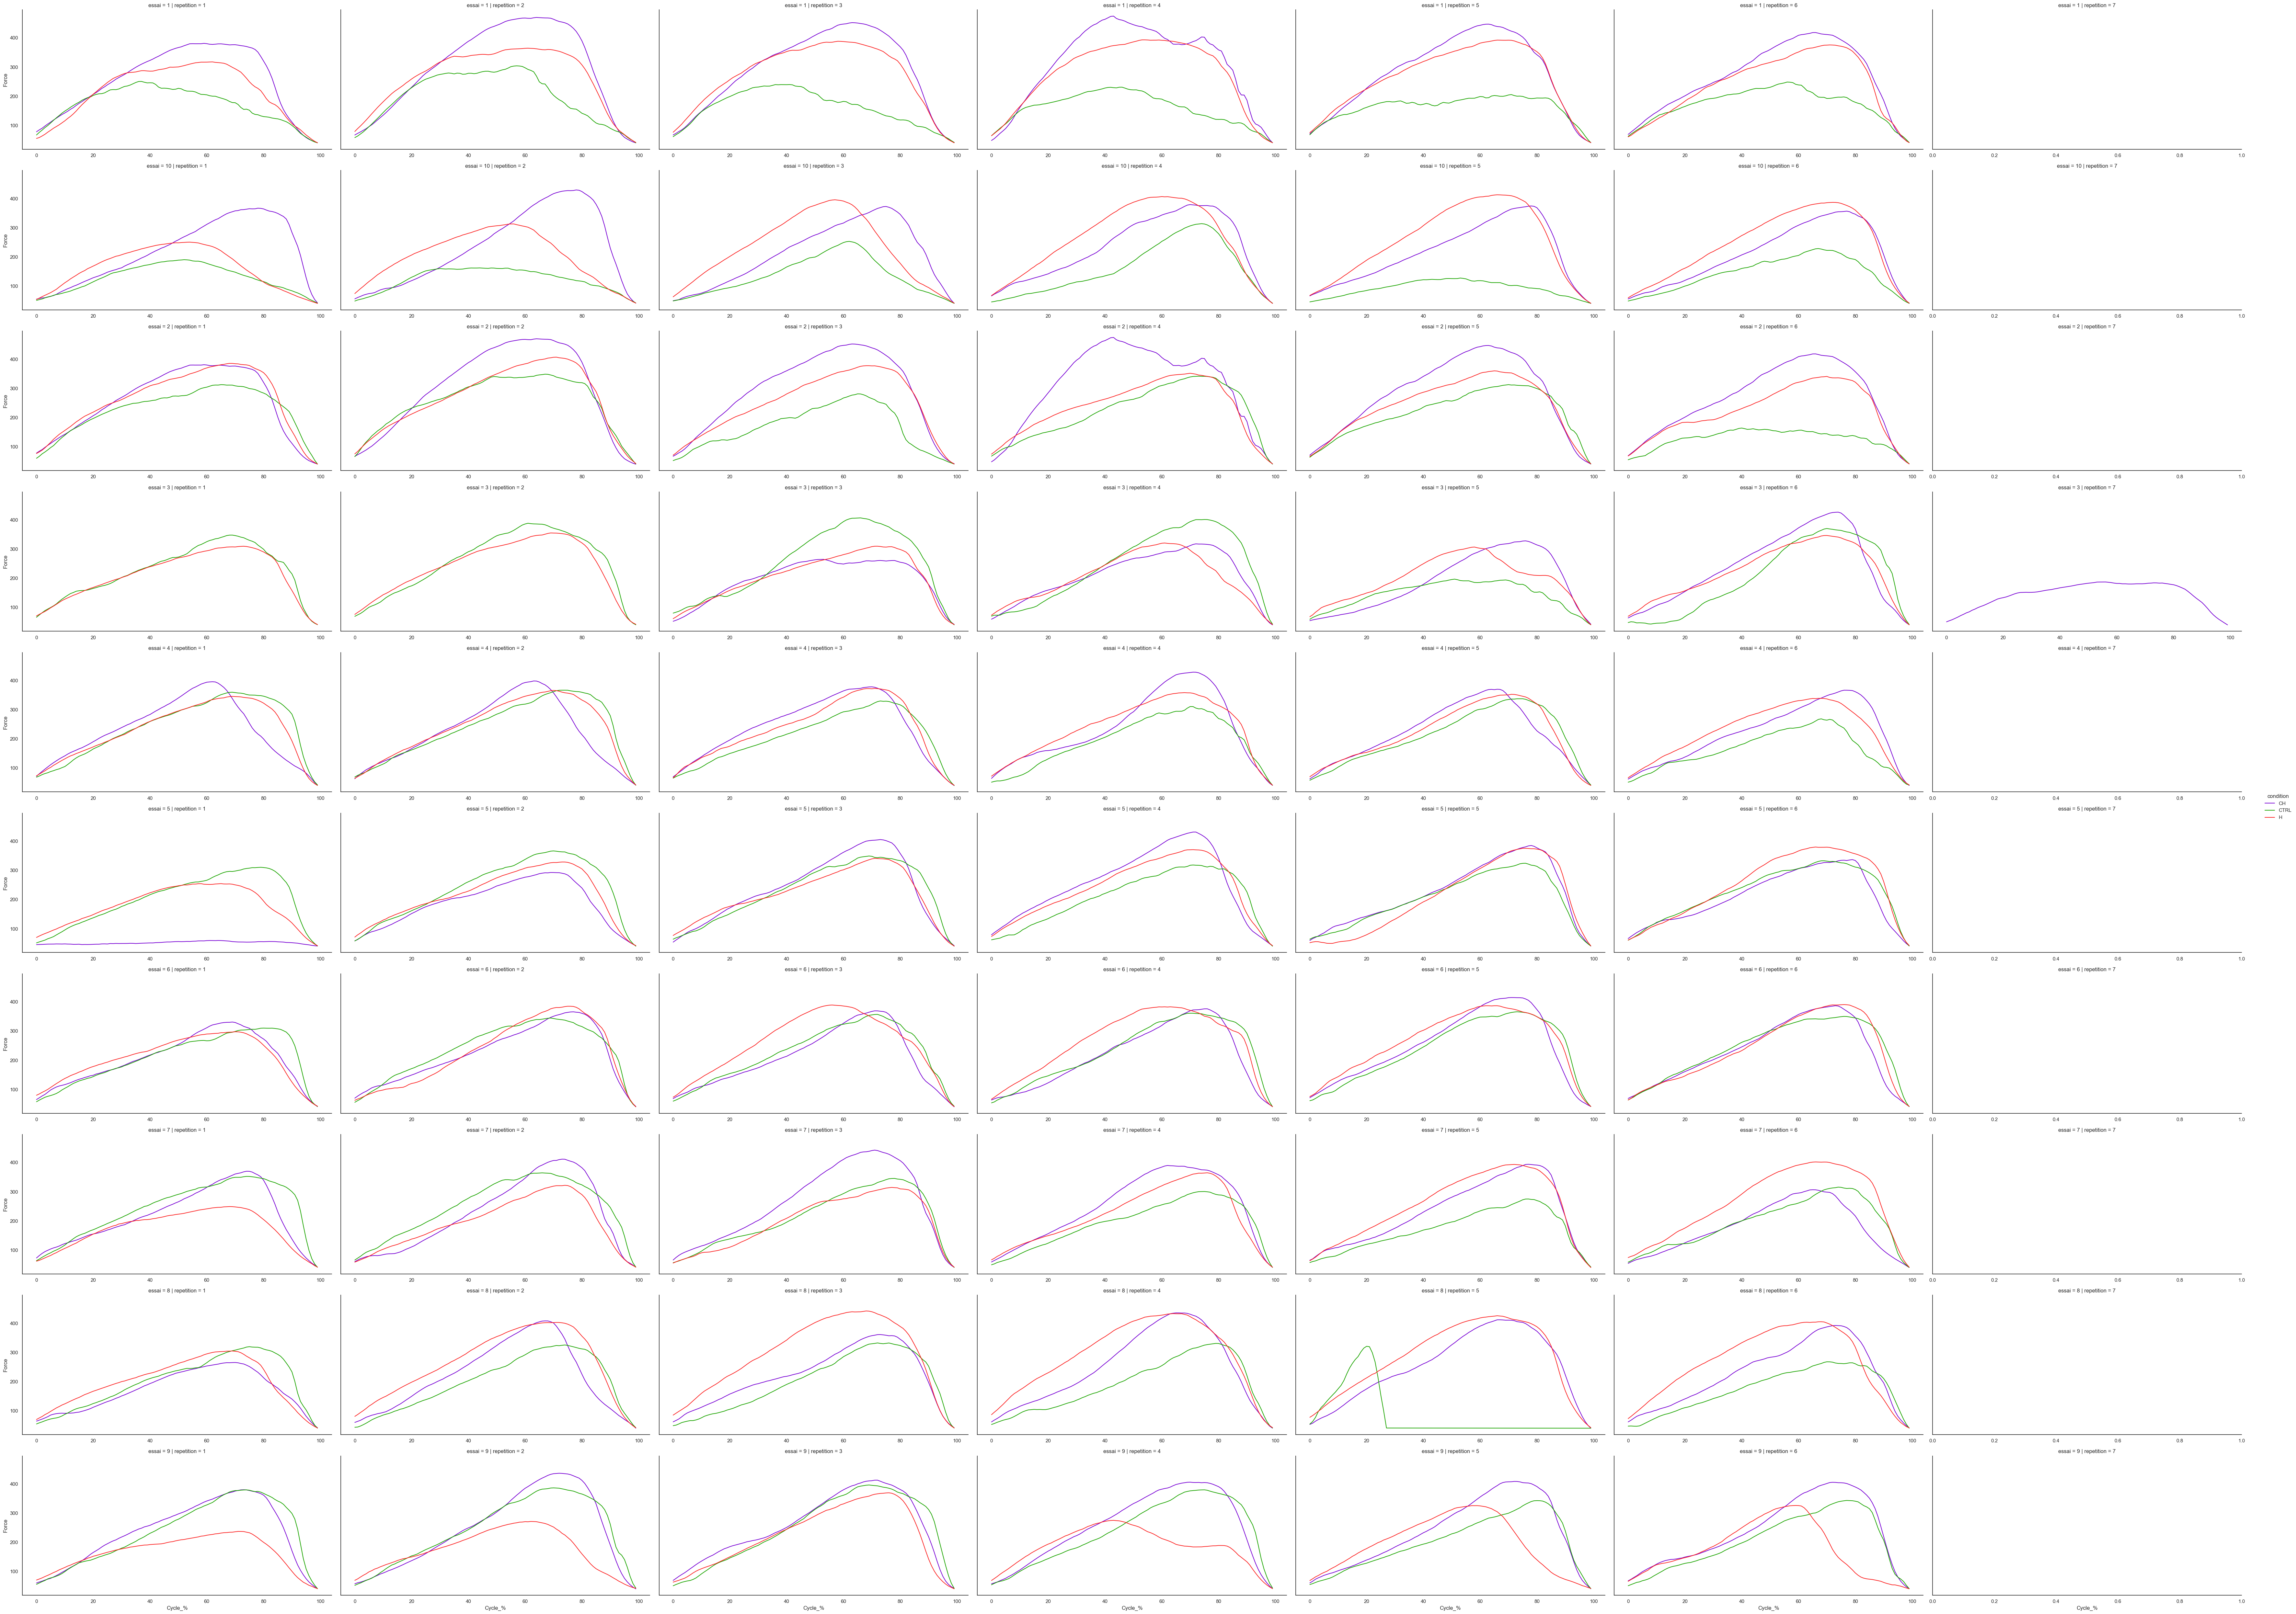

In [385]:
data_plot = df_flexion_interpol[
    (df_flexion_interpol['repetition'] != 0)
    & (df_flexion_interpol['mouvement'] == 'Extension')
    & (df_flexion_interpol['contraction'] == 'EXC')
    & (df_flexion_interpol['participant'] == '005')
    # & (df_flexion_interpol['repetition'] == '04')
]

palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

sns.relplot(data_plot, 
             x= 'Cycle_%',
             y = 'Force',
             hue= 'condition',
             kind = 'line',
             aspect= 2,
             row = 'essai',
             col = 'repetition',
             palette=palette_colors,
             facet_kws=dict(sharex=False),
             errorbar = 'sd'
             )

C:\Users\ESP Consulting\AppData\Local\Temp\ipykernel_3260\1402205466.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_plot = df_flexion_interpol[


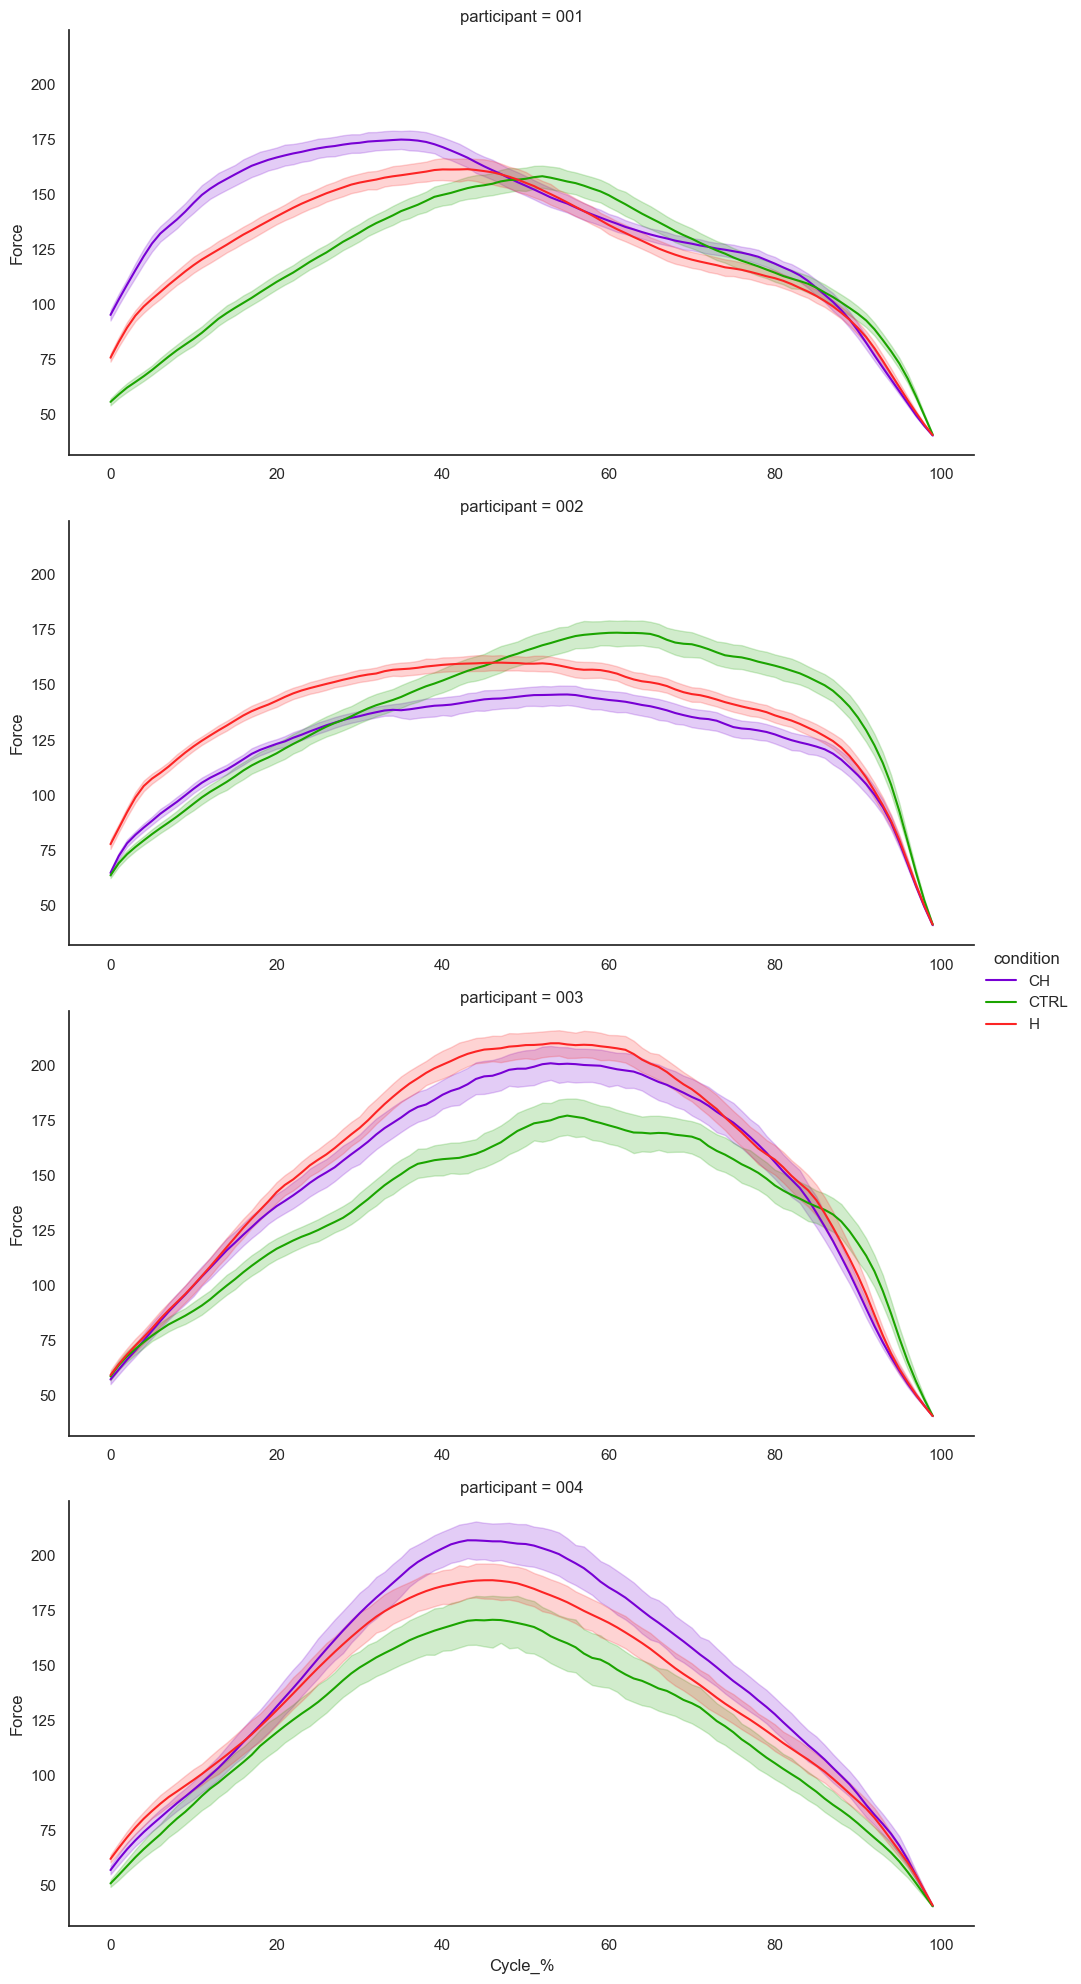

In [ ]:
data_plot = df_flexion_interpol[
    # (df_flexion_interpol['participant'] == '001')
    (df_flexion_interpol['repetition'] != 0)
    # & (df_force_phase['condition'] == 'CTRL')
    & (df_force_phase['contraction'] == 'EXC')
    # & (df_flexion_interpol['essai'] == '8')
    # (df_force_phase['mesure'] == '01')
    & (df_flexion_interpol['mouvement'] == 'Extension')
]

palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

sns.relplot(data_plot, 
            x= 'Cycle_%',
             y = 'Force',
             hue= 'condition',
             kind = 'line',
             aspect= 2,
             row = 'participant',
            #  col = 'participant',
             palette=palette_colors,
             facet_kws=dict(sharex=False)
             )


# Contraction isométrique

In [ ]:
# data_plot = df_flexion_interpol[
#     (df_flexion_interpol['repetition'] != 0)
#     & (df_flexion_interpol['mouvement'] == 'Extension')
#     & (df_flexion_interpol['contraction'] == 'ISO')
#     & (df_flexion_interpol['participant'] == '005')
#     & (df_flexion_interpol['mesure'] == '11')
# ]

# palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

# sns.relplot(data_plot, 
#              x= 'Cycle_%',
#              y = 'Force',
#              hue= 'condition',
#              kind = 'line',
#              aspect= 2,
#              row = 'essai',
#              col = 'repetition',
#              palette=palette_colors,
#              facet_kws=dict(sharex=False),
#              errorbar = 'sd'
#              )

In [ ]:
# data_plot = df_flexion_interpol[
#     # (df_flexion_interpol['participant'] == '001')
#     (df_flexion_interpol['repetition'] != 0)
#     # & (df_force_phase['condition'] == 'CTRL')
#     # & (df_force_phase['contraction'] == 'CON60')
#     # & (df_flexion_interpol['essai'] == '1')
#     # & (df_flexion_interpol['mesure'] == '01')
#     & (df_flexion_interpol['mouvement'] == 'Extension')
# ]

# palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

# sns.relplot(data_plot, 
#             x= 'Cycle_%',
#              y = 'Force',
#              hue= 'condition',
#              kind = 'line',
#              aspect= 2,
#              row = 'participant',
#             #  col = 'participant',
#              palette=palette_colors,
#              facet_kws=dict(sharex=False)
#              )

In [ ]:
# data_plot = df_flexion_interpol[
#     (df_flexion_interpol['participant'] == '001')
#     & (df_flexion_interpol['repetition'] != 0)
#     # & (df_force_phase['condition'] == 'CTRL')
#     # & (df_force_phase['contraction'] == 'CON60')
#     # & (df_flexion_interpol['essai'] == '1')
#     # & (df_flexion_interpol['mesure'] == '01')
#     & (df_flexion_interpol['mouvement'] == 'Extension')
# ]

# palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

# sns.relplot(data_plot, 
#             x= 'Cycle_%',
#              y = 'Force',
#              hue= 'condition',
#              kind = 'line',
#              aspect= 2,
#             #  row = 'repetition',
#              col = 'participant',
#              palette=palette_colors,
#              facet_kws=dict(sharex=False)
#              )

In [ ]:
# data_plot = df_column[
#     (df_column['participant'] == '001')
#     # & (df_column['repetition'] != 0)
#     & (df_column['condition'] == 'CTRL')
#     # & (df_force_phase['contraction'] == 'CON60')
#     # & (df_column['essai'] == '2')
#     & (df_column['mesure'] == '02')
#     # & (df_column['mouvement'] == 'Extension')
# ]

# palette_colors = {'CTRL': '#1BA400', 'H': '#FC2424', 'CH': '#7700D4'}

# sns.relplot(data_plot, 
#             x= 'Time',
#              y = 'Force',
#              hue= 'condition',
#              kind = 'line',
#              aspect= 2,
#             #  row = 'mesure',
#              col = 'participant',
#              palette=palette_colors,
#              facet_kws=dict(sharex=False)
#              )